In [1]:
cd ../..

/home/msi/projects/diplomka


In [2]:
import pandas as pd


In [3]:
import glob
import json
import matplotlib.pyplot as plt

In [4]:
import networkx as nx

In [5]:
from traced_v2.models.graph import GraphModel

In [6]:
graph_subscription = GraphModel.get_or_create_subscription(forgetting=True, local=True)

gm = GraphModel("src", "dest", graph_subscription=graph_subscription)

In [7]:
graph_subscription = GraphModel.get_or_create_subscription(forgetting=False, local=True)

gm2 = GraphModel("src", "dest", graph_subscription=graph_subscription)

In [8]:
files = sorted(glob.glob('data/sites/NDGF_T1-CSCS_LCG2/*.json'))

In [9]:
from tqdm import tqdm

In [10]:
from traced_v2.models.normal import NormalModel

In [11]:
tss = []

In [12]:

for f in tqdm(files):
    with open(f, 'r') as fp:
        data = json.load(fp)
    ts = data['timestamp']
    hops = data['asns']
    gm.log(ts, hops)
    gm2.log(ts, hops)
    tss.append(ts)

100%|██████████| 86828/86828 [00:21<00:00, 4091.22it/s]


In [13]:
index = pd.to_datetime(tss, unit='ms')

## comparison

In [14]:
import numpy as np

Text(0.5, 1.0, 'ASN paths log prob (no forgetting)')

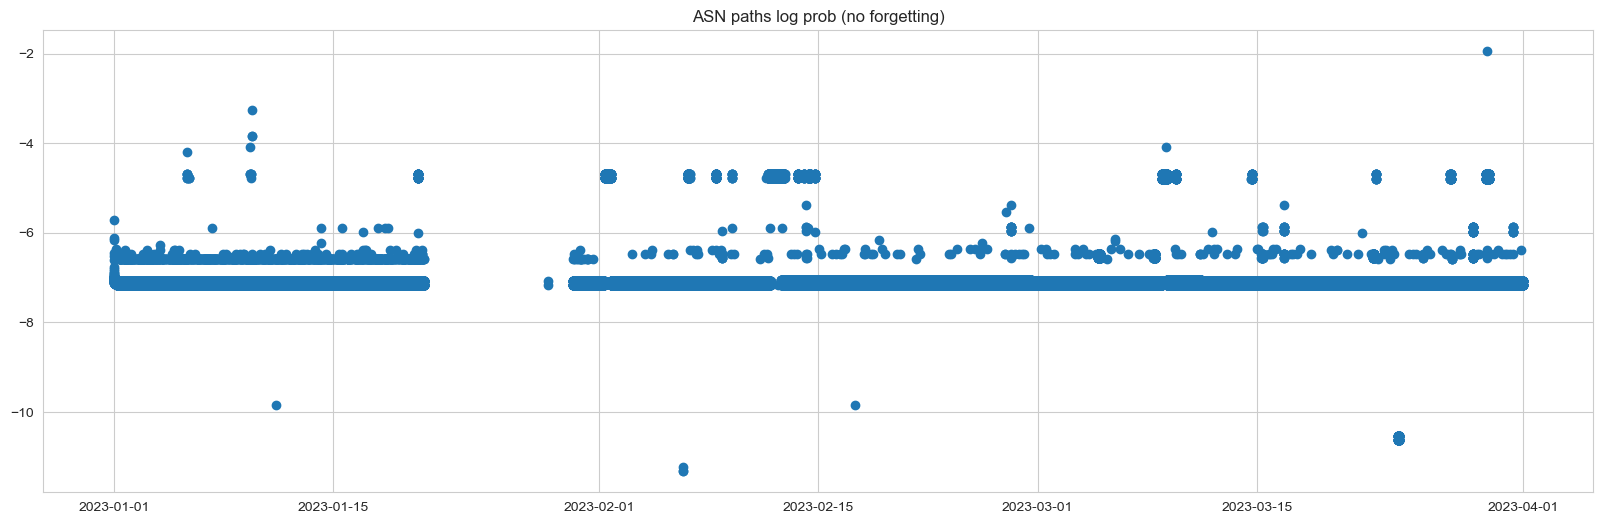

In [15]:
fig = plt.figure(figsize=(20, 6))
plt.plot(index, -np.array(gm2.probs), marker='o', linestyle='None')
plt.title("ASN paths log prob (no forgetting)")

Text(0.5, 1.0, 'ASN paths log prob (with forgetting)')

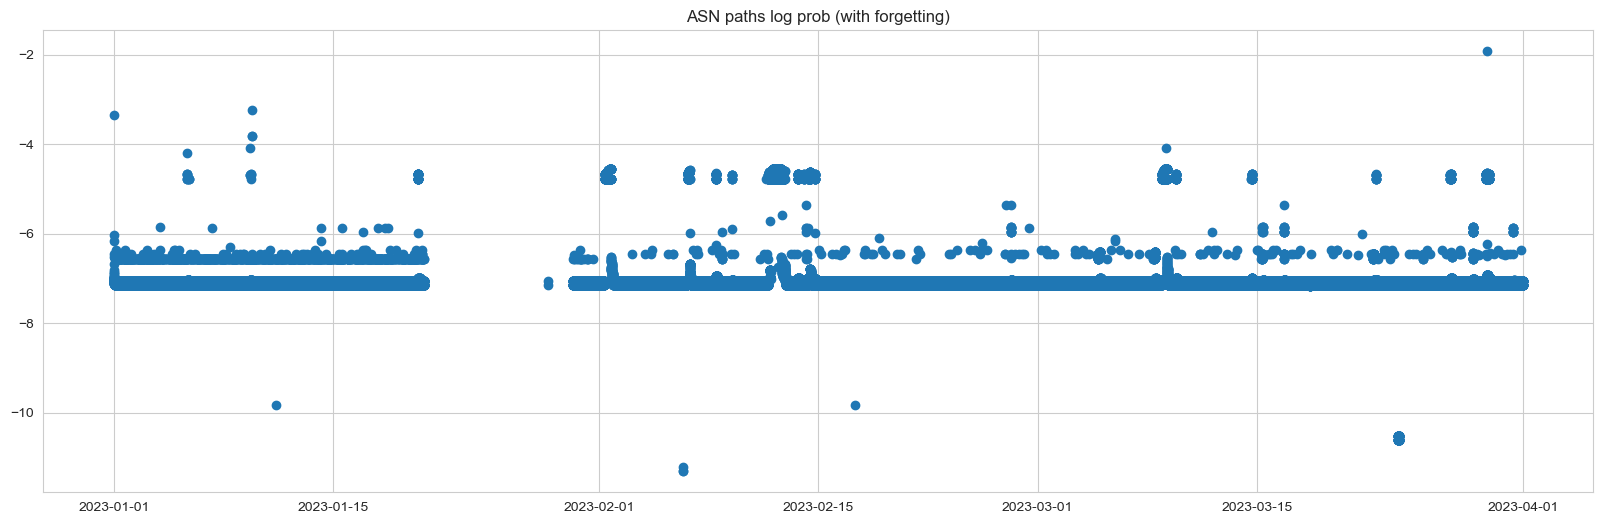

In [16]:
fig = plt.figure(figsize=(20, 6))
plt.plot(index, -np.array(gm.probs), marker='o', linestyle='None')
plt.title("ASN paths log prob (with forgetting)")

In [17]:
nm = NormalModel("src", "dest", one_sided=True, mu_0=-1, sigma_0=1, alpha_0=1, beta_0=1, sigma_factor=3)

In [18]:
for i, x in zip(tss, -np.array(gm2.probs)):
    nm.log(i, x)

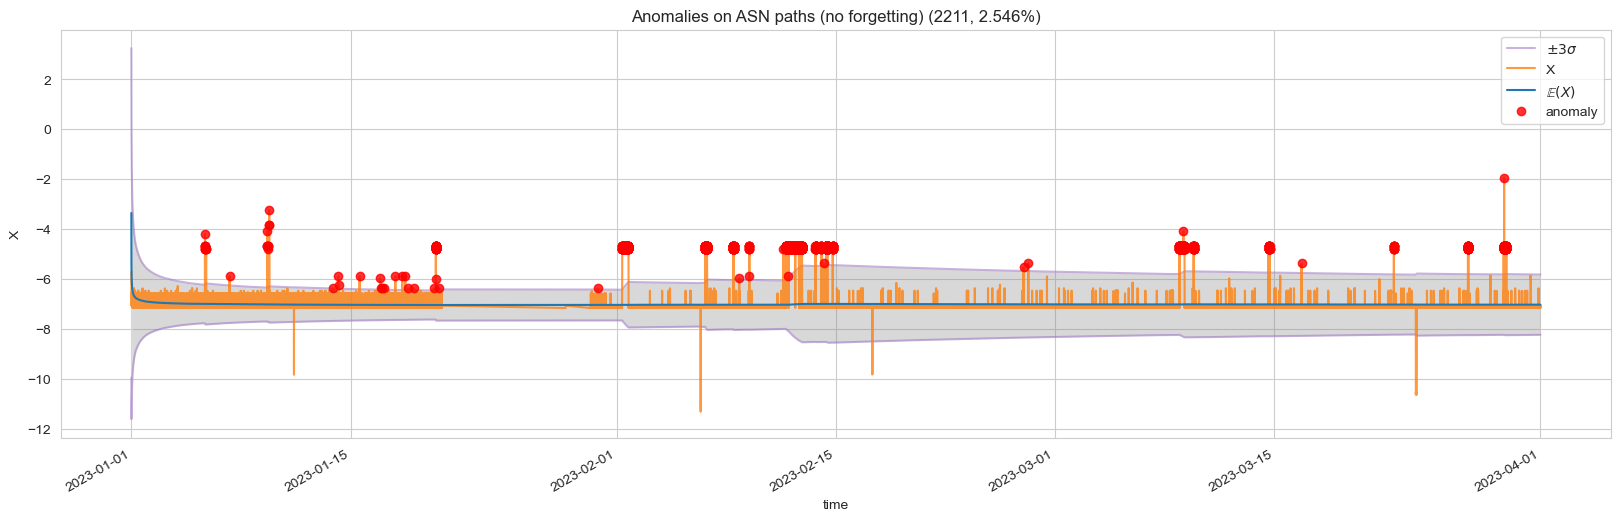

In [19]:
fig = plt.figure(figsize=(20, 6))
nm.plot(kind="ASN paths (no forgetting)")

In [20]:
nm = NormalModel("src", "dest", one_sided=True, mu_0=-1, sigma_0=1, alpha_0=1, beta_0=1, sigma_factor=3)

In [21]:
for i, x in zip(tss, -np.array(gm.probs)):
    nm.log(i, x)

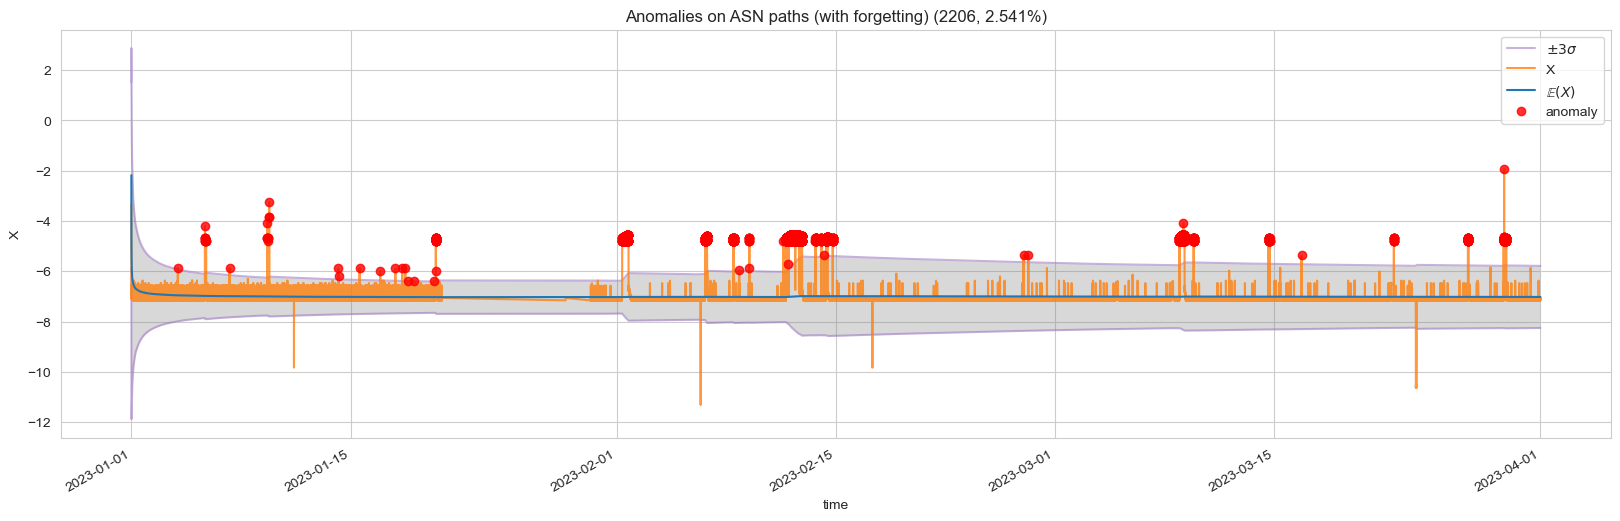

In [22]:
fig = plt.figure(figsize=(20, 6))
nm.plot(kind="ASN paths (with forgetting)")

# IPS


In [23]:
graph_subscription = GraphModel.get_or_create_subscription(forgetting=True, local=True)

gm = GraphModel("src", "dest", graph_subscription=graph_subscription)

In [24]:
graph_subscription = GraphModel.get_or_create_subscription(forgetting=False, local=True)

gm2 = GraphModel("src", "dest", graph_subscription=graph_subscription)

In [25]:
files = sorted(glob.glob('data/sites/GLOW-CSCS_LCG2/*.json'))

In [26]:
from tqdm import tqdm

In [27]:
tss = []

In [28]:
files = sorted(glob.glob('data/sites/GLOW-CSCS_LCG2/*.json'))

In [29]:
for f in tqdm(files):
    with open(f, 'r') as fp:
        data = json.load(fp)
    ts = data['timestamp']
    hops = data['hops']
    gm.log(ts, hops)
    gm2.log(ts, hops)
    tss.append(ts)

100%|██████████| 96145/96145 [00:22<00:00, 4228.25it/s]


## comparison

In [30]:
import numpy as np

In [31]:
index = pd.to_datetime(tss, unit='ms')

Text(0.5, 1.0, 'IP paths log prob (no forgetting)')

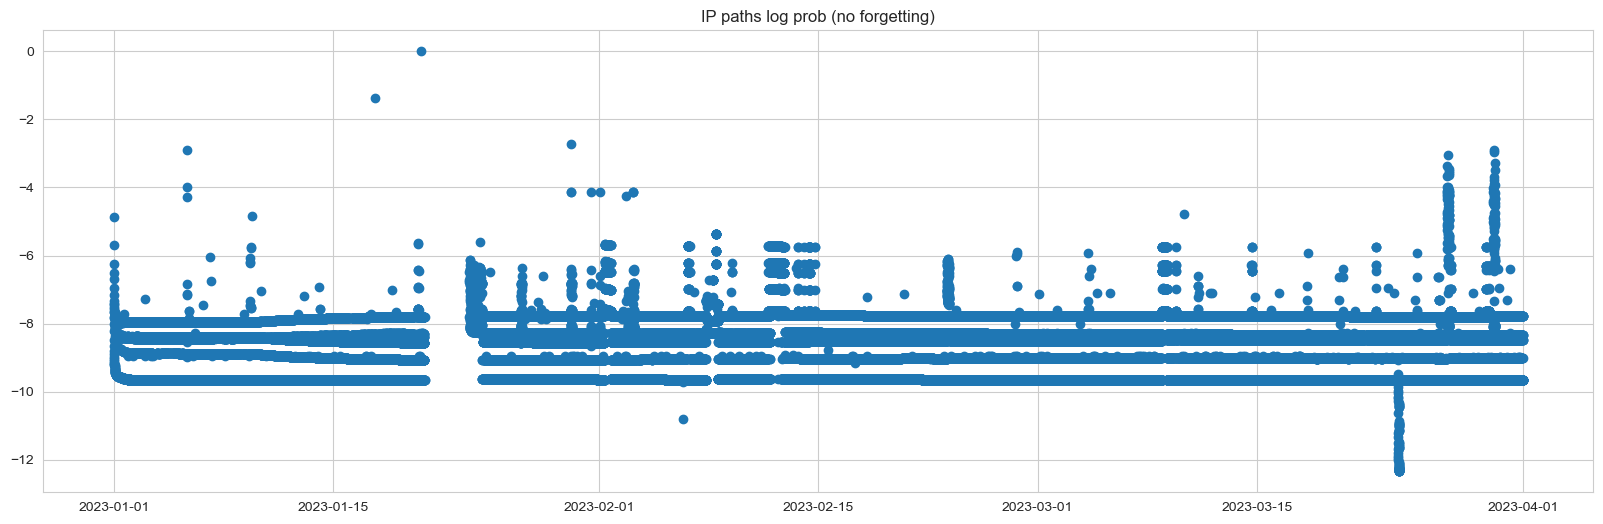

In [32]:
fig = plt.figure(figsize=(20, 6))

plt.plot(index, -np.array(gm2.probs), marker='o', linestyle='None')
plt.title("IP paths log prob (no forgetting)")

Text(0.5, 1.0, 'IP paths log prob (with forgetting)')

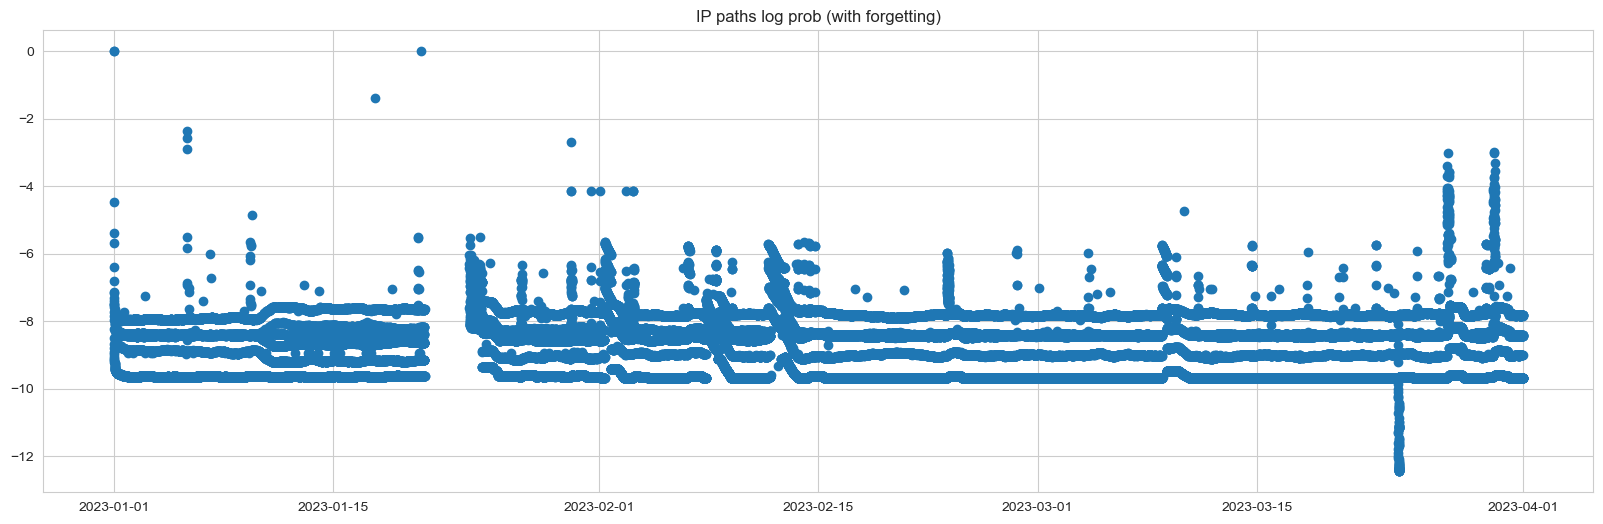

In [33]:
fig = plt.figure(figsize=(20, 6))
plt.plot(index, -np.array(gm.probs), marker='o', linestyle='None')
plt.title("IP paths log prob (with forgetting)")

In [34]:
nm = NormalModel("src", "dest", one_sided=True, mu_0=-1, sigma_0=1, alpha_0=1, beta_0=1, sigma_factor=4)

In [35]:
for i, x in zip(tss, -np.array(gm2.probs)):
    nm.log(i, x)

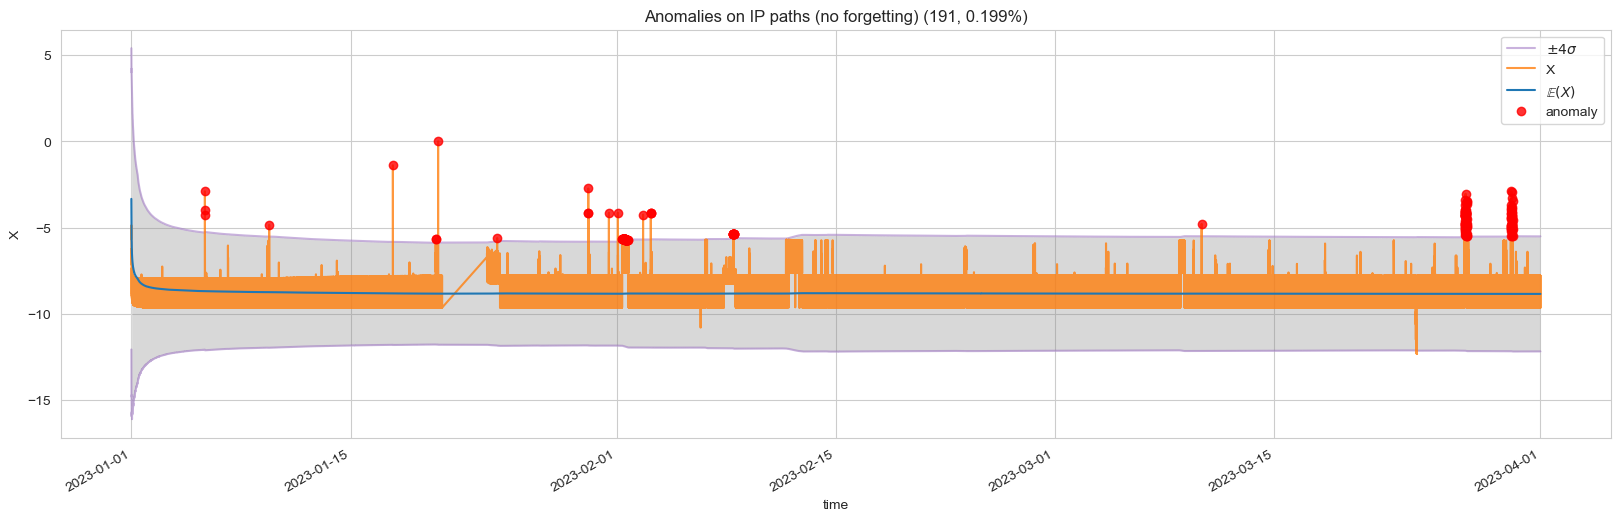

In [36]:
fig = plt.figure(figsize=(20, 6))
nm.plot(kind="IP paths (no forgetting)")

In [37]:
nm = NormalModel("src", "dest", one_sided=True, mu_0=-1, sigma_0=1, alpha_0=1, beta_0=1, sigma_factor=4)

In [38]:
for i, x in zip(tss,-np.array(gm.probs)):
    nm.log(i, x)

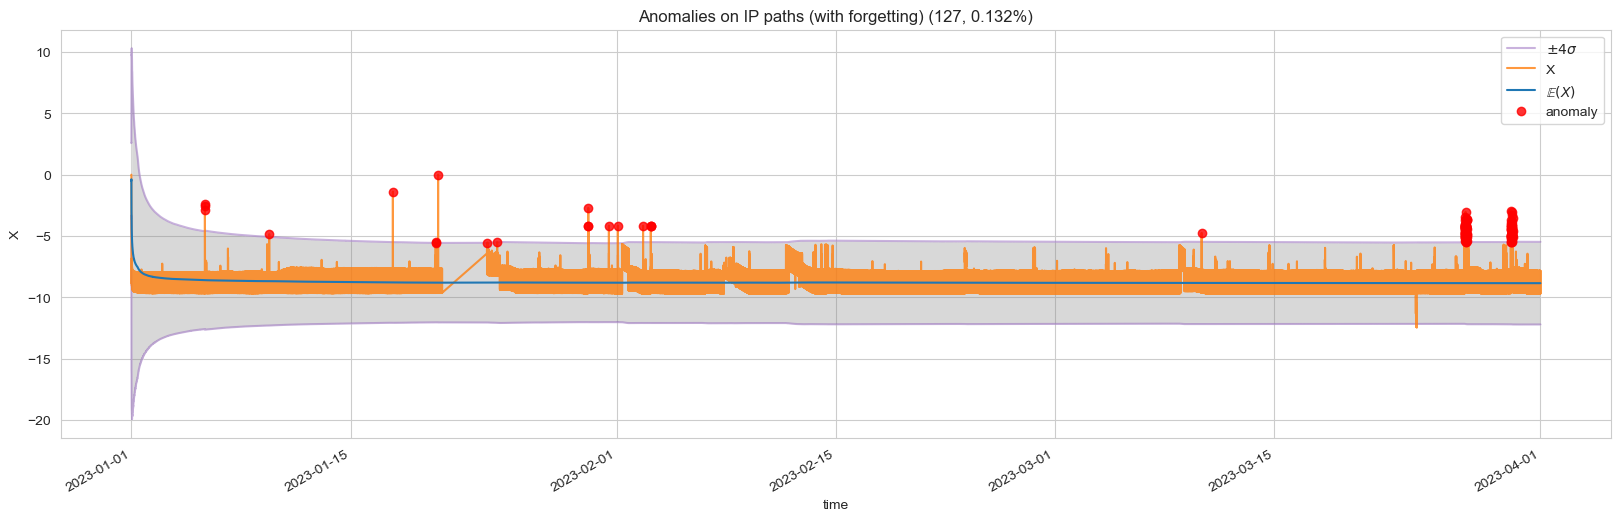

In [39]:
fig = plt.figure(figsize=(20, 6))
nm.plot(kind="IP paths (with forgetting)")

In [40]:
import json


In [41]:
with open("results\node_positions.json", 'r') as f:
    layout = json.loads(f.read())

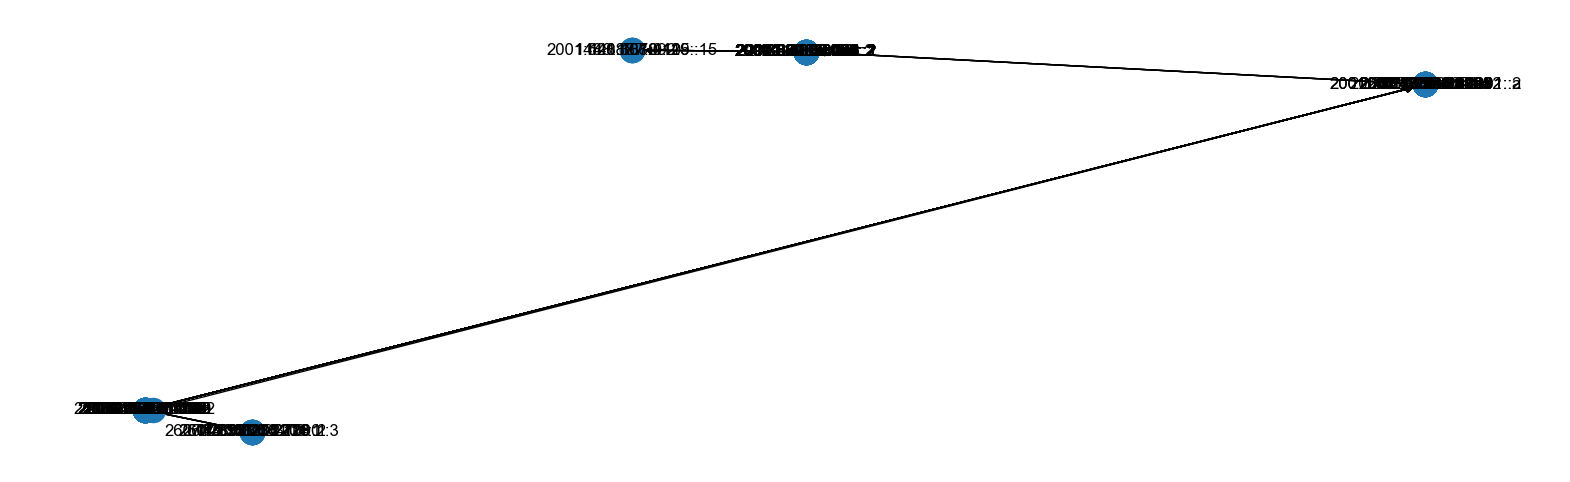

In [42]:
fig = plt.figure(figsize=(20, 6))
gm.plot(ax=fig.gca(), layout=layout)

In [43]:
graph = gm2.graph.to_graph()

In [44]:
import folium


In [45]:
center = np.mean([np.array(layout[x]) for x in graph.nodes()], axis=0)

In [46]:
# m = folium.Map(location=[46.02444, 8.96008], height='90%',  zoom_start=3, tiles="Stamen Toner")
m = folium.Map(location=center, height='100%',  zoom_start=3, tiles="Stamen Toner")
# folium.TileLayer('OpenStreetMap').add_to(m)

In [47]:
layer = folium.FeatureGroup(name=f"Nodes")
for node in graph.nodes():
    is_source = (0 == graph.in_degree(node))
    is_dest = (0 == graph.out_degree(node))
    icon = folium.Icon(color='red', icon='house', prefix='fa') if (is_dest or is_source) else folium.Icon(color='blue', icon='cloud', prefix='fa')
    folium.Marker(
        layout[node], popup=node, tooltip=node, icon=icon).add_to(layer)
m.add_child(layer);


In [48]:
layer = folium.FeatureGroup(name=f"edges")

for u, v, data in graph.edges(data=True):
    prob = data['weight']
    color = 'red'
    pos = [layout[u], layout[v]]
    e = folium.PolyLine(pos, color=color,  weight=prob*8, tooltip=prob, opacity=0.2,
    ).add_to(layer) 
    # folium.RegularPolygonMarker(location=node_pos[edge['dest']], color=color, number_of_sides=3, radius=10, ).add_to(m)
layer.add_to(m);


In [49]:
display(m)

In [50]:
GraphModel.REGISTRY

{'global': <traced_v2.models.graph.Graph at 0x7fd75e8143a0>,
 'global_forgetting': <traced_v2.models.graph.ForgettingGraph at 0x7fd75e814400>,
 'global_ip': <traced_v2.models.graph.Graph at 0x7fd75e814610>,
 'global_forgetting_ip': <traced_v2.models.graph.ForgettingGraph at 0x7fd77c61bf10>,
 'global_as': <traced_v2.models.graph.Graph at 0x7fd77c618070>,
 'global_forgetting_as': <traced_v2.models.graph.ForgettingGraph at 0x7fd77c618040>,
 '53fe3b6b2f497235194ef2b22d3f95a6236c3c9a': <traced_v2.models.graph.ForgettingGraph at 0x7fd77c61b6a0>,
 'cb9945d710838e711ad2bcfe691e84e7bfea9fe0': <traced_v2.models.graph.Graph at 0x7fd77c619630>,
 '8b721ebb3e8daa6dc6ab466101ba78062201ec28': <traced_v2.models.graph.ForgettingGraph at 0x7fd754125330>,
 '5e50e1433f9fb0805a066ef64fb73715e87c97b0': <traced_v2.models.graph.Graph at 0x7fd754126860>}